<a href="https://colab.research.google.com/github/sboonpan/DMLP_SET50/blob/main/NN_Work_16_1_Canser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

เป็นชุดข้อมูลเกี่ยวกับมะเร็ง(Breast canser)ซึ่งได้จากข้อมูลภาพกิจิทอลของชิ้นเนื้อ เก็บโดยการใช้เข็มเจาะเพื่อดูดชิ้นเนื้อหรือเซลล์(FNA:Fine Needle Aspiration) นำไปตรวจแล้วบันทึกข้อมูล แต่ละเคส(แต่ละ sample) มีรายละเอียดดังนี้

1. ชุดข้อมูลมีจำนวน 560 รายการ(560 sampleห)
2. Feature: จำนวน 30 คอลัมน์(30 ตัวแปร) ประกอบด้วยค่าขนาดต่างๆของ samples เช่น รัศมีเฉลี่ย(mean radius) ค่าส่วนเบี่ยงเบนมาตรฐาน Pixel ค่าความเรียบ พื้นที่(area) และอื่นๆ 
3. Class/Target/Label : สถานะหรือผลตรวจ 0 คือ Maligant(เนื้อร้ายหรือมะเร็ง) และ 1 คือ Benign ไม่เป็นมะเร็ง


## 1: เตรียมข้อมูล

In [ ]:
from sklearn.datasets import load_breast_cancer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
cancer = load_breast_cancer()
cancer

{'DESCR': '.. _breast_cancer_dataset:\n\nBreast cancer wisconsin (diagnostic) dataset\n--------------------------------------------\n\n**Data Set Characteristics:**\n\n    :Number of Instances: 569\n\n    :Number of Attributes: 30 numeric, predictive attributes and the class\n\n    :Attribute Information:\n        - radius (mean of distances from center to points on the perimeter)\n        - texture (standard deviation of gray-scale values)\n        - perimeter\n        - area\n        - smoothness (local variation in radius lengths)\n        - compactness (perimeter^2 / area - 1.0)\n        - concavity (severity of concave portions of the contour)\n        - concave points (number of concave portions of the contour)\n        - symmetry\n        - fractal dimension ("coastline approximation" - 1)\n\n        The mean, standard error, and "worst" or largest (mean of the three\n        worst/largest values) of these features were computed for each image,\n        resulting in 30 features.

In [ ]:
# ตรวจดูว่ามี key อะไรบ้างในข้อมูล
cancer.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

สิ่งที่ปรากฎคือ dick_key ทั้งหมด ในที่นี้ต้องการใช้ data และ feature_names นำข้อมูลมาทำเป็น Dataframe เพื่อให้ง่ายต่อการเอาไปใช้ประมวลผล โดยโปรเจคนี้เป็นโปรเจคเริ่มต้นเพื่อศึกษาการใช้คำสั่งต่างๆ จึงยกตัวอย่าง feature ทีจะใช้เพียงแค่ 2 feature เท่านั้น จากทั้งหมด 30 ฟีเจอร์ จากนั้นจะตรวจสอบข้อมูลด้วย .sample ( กำหนด random_state คือการสุ่มให้ได้เหมื่อนเดิมทุกคร้่ง) 

In [ ]:
# data and feature selected only 2 column
df = pd.DataFrame(cancer.data[ : , 0:2], columns = cancer.feature_names[0:2])
df['class'] = cancer.target 
df.sample(5, random_state = 1)

,mean radius,mean texture,class
421,14.69,13.98,1
47,13.17,18.66,0
292,12.95,16.02,1
186,18.31,18.58,0
414,15.13,29.81,0


In [ ]:
# ตรวจสอบดูว่ามีข้อมูลสูญหายหรือไม่ 0 หมายถึงไม่มีข้อมูลสูญหาย
df.isnull().sum()

mean radius     0
mean texture    0
class           0
dtype: int64

## ตรวจดูข้อมูลด้วย scatter plot

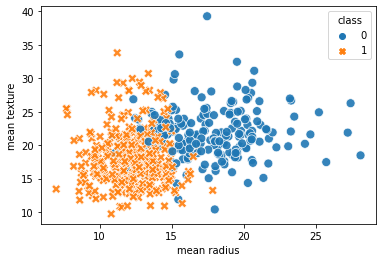

In [ ]:
sns.scatterplot(x = 'mean radius', y ='mean texture', data = df, hue = 'class', style = 'class',
                alpha = 0.9, edgecolor = 'w', s = 80)

In [ ]:
class_names, y = np.unique(df['class'], return_inverse=True)
class_names

array([0, 1])

### เตรียมข้อมูล Feature โดยตัดคอลัมน์ class ออกไป

In [ ]:
X = df.drop('class', axis = 1)
X

,mean radius,mean texture
0,17.99,10.38
1,20.57,17.77
2,19.69,21.25
3,11.42,20.38
4,20.29,14.34
...,...,...
564,21.56,22.39
565,20.13,28.25
566,16.60,28.08
567,20.60,29.33


## ปรับค่าข้อมูลเป็น standard scale

โดยทั่วไป ในชุดข้อมูล อาจจมีฟิเจอร์บางตัวที่มีช่วงสเกลแตกต่างกัน เช่น ข้อมูลบุคคลมีความสูงหน่วยเมตร น้ำหนักหน่วยกิโลกรัม จะเห็นว่า ค่าความสูงอยู่ระหว่าง 1.0 - 2.0 เมตร แต่น้ำหนักจะอยู่ระหว่าง 35-80 กิโลกรัม ลักษณะนี้ ค่าแตกต่างจะมีผลให้การคำนวณค่า weight ไม่สมดุลย์กัน เช่นค่าน้ำหนักของแต่ละคนอาจต่างกัน 3-5 กิโลกรัม แต่ความสูงอาจต่างกันในช่วง 0.1 - 0.2 เมตร ดังนั้น ผลการคำนวณค่า feature ของน้ำหนักจะกลายเป็นตัวที่มีผลมากกว่า ซึ่งถือว่าไม่ดี
ดังนั้นเพื่อให้เกิดความเสมอภาค จะต้องทำการปรับสเกล Feature มาเป็นสเกลเดียวกันเรียกว่า Feature scaling หรือ Data scaling ซึ่งมีหลายวิธีด้วยกัน วิธีที่นิยมวิธีหนึ่งคือ การทำ standard scalar( Z-score) ซึ่งมีหลักการคล้ายๆกันการทำ normalize ที่จะทำให้ปรับสเกล min-max กลายเป็น 0-1 ) แต่ standard scalar จะทำให้ข้อมูลทุกคอลัมน์ มีค่าเฉลี่ยเป็นศูนย์ และค่าส่วนเบี่ยงเบนมาตรฐานเป็น 1 (mean = 0, SD = 1) ในที่นี้จะได้ scikit-learn ปรับค่าสเกลของค่า x 

In [ ]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_sc = sc.fit_transform(X)
X_sc[:5]

array([[ 1.09706398, -2.07333501],
       [ 1.82982061, -0.35363241],
       [ 1.57988811,  0.45618695],
       [-0.76890929,  0.25373211],
       [ 1.75029663, -1.15181643]])

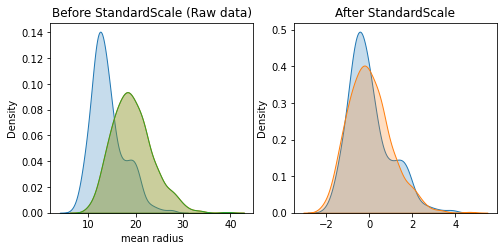

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 3.5))

ax1.set_title('Before StandardScale (Raw data)')
sns.kdeplot(df['mean radius'], fill=True, ax=ax1)
sns.kdeplot(df['mean texture'], fill=True, ax=ax1)

ax2.set_title('After StandardScale')
sns.kdeplot(X_sc[:,0], fill=True, ax=ax2)
sns.kdeplot(X_sc[:,1], fill=True, ax=ax2)
sns.kdeplot(df['mean texture'], fill=True, ax=ax1)

plt.show()

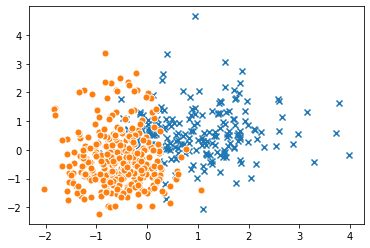

In [ ]:
plt.scatter(X_sc[:,0][y==0], X_sc[:,1][y==0], marker='x')
plt.scatter(X_sc[:,0][y==1], X_sc[:,1][y==1], edgecolor='w', s=50)
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_sc, y, test_size=0.25, random_state=1) #

X_train.shape, X_test.shape

((426, 2), (143, 2))

In [ ]:
y_train.shape, y_test.shape 

((426,), (143,))

# การสร้างโมเดล

### การเขียนโค้ดในรูปแบบ Sequential Model

มีลักษณะเป็นลำดับ(Sequence) เหมือนกับการสร้างชั้น layer ต่อๆกันไป เช่น เริ่ม instance ตัวโมเดลก่อน จากนั้นก็เพิ่ม layer เข้าไปทีละชั้น(.add) โดยแต่ละชั้นกำหนดจำนวน Node ที่ต้องการด้วย Dense ดังนี้

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

In [ ]:
input_size = X_train.shape[-1]
input_size

2

In [ ]:
model = Sequential([
                    Dense(32, activation = 'relu', input_shape = (input_size,)),
                    Dense(1, activation = 'sigmoid')
])


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                96        
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 129
Trainable params: 129
Non-trainable params: 0
_________________________________________________________________


หากต้องการดูรายละเอียดในแต่ละชั้น

In [ ]:
model.get_config()

{'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 2),
    'dtype': 'float32',
    'name': 'dense_input',
    'ragged': False,
    'sparse': False}},
  {'class_name': 'Dense',
   'config': {'activation': 'relu',
    'activity_regularizer': None,
    'batch_input_shape': (None, 2),
    'bias_constraint': None,
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'bias_regularizer': None,
    'dtype': 'float32',
    'kernel_constraint': None,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': None}},
    'kernel_regularizer': None,
    'name': 'dense',
    'trainable': True,
    'units': 32,
    'use_bias': True}},
  {'class_name': 'Dense',
   'config': {'activation': 'sigmoid',
    'activity_regularizer': None,
    'bias_constraint': None,
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'bias_regularizer': None,
    'dtype': 'float32',
    'kernel_constraint': None,
    'kernel_initializer': 

หากต้องการดูมิติ shape ของ output layer

In [ ]:
model.output_shape

(None, 1)

# การ compile model

การสั่งคอมไพล์ โดยกำหนดพารามิเตอร์ การวัดค่า Loss, Optimizer และมิติของการวัด(metrics)

In [ ]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

# การเทรนโมเดล 

เมื่อเรียบร้อยแล้ว สั่ง train ด้วย .fit() ซึ่งพารามิเตอร์สำหรับการ train ประกอบด้วย

X, y คือ ข้อมูล Feature และ Label 

epochs คือ จำนวนรอบในการทำ Backpropagation ปรับ weight 

batch_size คือ จำนวนข้อมูล(จำนวน sample) ที่นำเข้าประมวลผลในแต่ละครั้ง

validation_split คือ สัดส่วนในการแบ่งข้อมูลมาเป็นตัวประเมินทดสอบหรือ validate

verbose = 1 ให้แสดงรายละเอียดสถานะในแต่ละ Epoch ถ้าไม่ต้องการแสดงก็ตั้ง verbose = 0 ระบบจะ train แบบเงียบๆ

In [ ]:
import time

start = time.time()

history = model.fit(X_train, y_train, epochs=20, verbose=1, batch_size=32, validation_split=0.25)

end = time.time()

print(f"Runtime of the program is {end - start} secs")
print("Time Taken: {:.3f} secs".format(end - start))

Epoch 1/20
10/10 [==============================] - 0s 8ms/step - loss: 0.2027 - accuracy: 0.9185 - val_loss: 0.2310 - val_accuracy: 0.9065
Epoch 2/20
10/10 [==============================] - 0s 5ms/step - loss: 0.2022 - accuracy: 0.9185 - val_loss: 0.2304 - val_accuracy: 0.9065
Epoch 3/20
10/10 [==============================] - 0s 6ms/step - loss: 0.2018 - accuracy: 0.9185 - val_loss: 0.2298 - val_accuracy: 0.9065
Epoch 4/20
10/10 [==============================] - 0s 6ms/step - loss: 0.2014 - accuracy: 0.9185 - val_loss: 0.2293 - val_accuracy: 0.9065
Epoch 5/20
10/10 [==============================] - 0s 6ms/step - loss: 0.2011 - accuracy: 0.9185 - val_loss: 0.2288 - val_accuracy: 0.9065
Epoch 6/20
10/10 [==============================] - 0s 5ms/step - loss: 0.2008 - accuracy: 0.9216 - val_loss: 0.2290 - val_accuracy: 0.9065
Epoch 7/20
10/10 [==============================] - 0s 5ms/step - loss: 0.2004 - accuracy: 0.9216 - val_loss: 0.2285 - val_accuracy: 0.9065
Epoch 8/20
10/10 [==

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.35299742221832275
Test accuracy: 0.8531468510627747
